<a id="3.1"></a>
<h2 style="font-family: Verdana; font-size: 25px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: #0A800B;"><b>Cài đặt các thư viện cần thiết </b></h2>

In [1]:
!pip install transformers peft accelerate \
    -U --no-index --find-links /kaggle/input/lmsys-wheel-files

Looking in links: /kaggle/input/lmsys-wheel-files
Processing /kaggle/input/lmsys-wheel-files/peft-0.11.1-py3-none-any.whl


In [2]:
%%capture
!pip install --no-index /kaggle/input/bitsandbytes0-42-0/bitsandbytes-0.42.0-py3-none-any.whl --find-links=/kaggle/input/bitsandbytes0-42-0

In [3]:
from tqdm.auto import tqdm
from bs4 import BeautifulSoup
import gc
import pandas as pd
import pickle
import sys
import numpy as np
from tqdm.autonotebook import trange
from sklearn.model_selection import GroupKFold
import json
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from numpy.linalg import norm
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel,BitsAndBytesConfig
from peft import (
    LoraConfig,
    get_peft_model,
)
import json
import copy
import warnings
import os
warnings.filterwarnings('ignore')

<a id="3.1"></a>
<h2 style="font-family: Verdana; font-size: 25px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: #0A800B;"><b>Load dữ liệu </b></h2>

In [4]:
train = pd.read_csv("/kaggle/input/eedi-mining-misconceptions-in-mathematics/train.csv")
test = pd.read_csv("/kaggle/input/eedi-mining-misconceptions-in-mathematics/test.csv")
sub = pd.read_csv("/kaggle/input/eedi-mining-misconceptions-in-mathematics/sample_submission.csv")
misconception_mapping  = pd.read_csv("/kaggle/input/eedi-mining-misconceptions-in-mathematics/misconception_mapping.csv")

In [5]:
train.head()

,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerAText,AnswerBText,AnswerCText,AnswerDText,MisconceptionAId,MisconceptionBId,MisconceptionCId,MisconceptionDId
0,0,856,Use the order of operations to carry out calcu...,33,BIDMAS,A,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...,\( 3 \times(2+4)-5 \),\( 3 \times 2+(4-5) \),\( 3 \times(2+4-5) \),Does not need brackets,NaN,NaN,NaN,1672.0
1,1,1612,Simplify an algebraic fraction by factorising ...,1077,Simplifying Algebraic Fractions,D,"Simplify the following, if possible: \( \frac{...",\( m+1 \),\( m+2 \),\( m-1 \),Does not simplify,2142.0,143.0,2142.0,NaN
2,2,2774,Calculate the range from a list of data,339,Range and Interquartile Range from a List of Data,B,Tom and Katie are discussing the \( 5 \) plant...,Only\nTom,Only\nKatie,Both Tom and Katie,Neither is correct,1287.0,NaN,1287.0,1073.0
3,3,2377,Recall and use the intersecting diagonals prop...,88,Properties of Quadrilaterals,C,The angles highlighted on this rectangle with ...,acute,obtuse,\( 90^{\circ} \),Not enough information,1180.0,1180.0,NaN,1180.0
4,4,3387,Substitute positive integer values into formul...,67,Substitution into Formula,A,The equation \( f=3 r^{2}+3 \) is used to find...,\( 30 \),\( 27 \),\( 51 \),\( 24 \),NaN,NaN,NaN,1818.0


<a id="3.1"></a>
<h2 style="font-family: Verdana; font-size: 25px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: #0A800B;"><b>Khám phá dữ liệu</b></h2>

In [6]:
train.columns

Index(['QuestionId', 'ConstructId', 'ConstructName', 'SubjectId',
       'SubjectName', 'CorrectAnswer', 'QuestionText', 'AnswerAText',
       'AnswerBText', 'AnswerCText', 'AnswerDText', 'MisconceptionAId',
       'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId'],
      dtype='object')

Kiểu dữ liệu của mỗi cột

In [ ]:
train.dtypes

Kiểm tra giá trị thiếu trong tập train

In [7]:
missing_values = train[['MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']].isnull().sum()

print("Missing values per Misconception column:")
print(missing_values)

Missing values per Misconception column:
MisconceptionAId    734
MisconceptionBId    751
MisconceptionCId    789
MisconceptionDId    832
dtype: int64


Điền giá trị thiếu bằng giá trị -1

In [8]:
train[['MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']] = train[['MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']].fillna(-1)

missing_values_after = train[['MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']].isnull().sum()

print("Missing values after filling:")
print(missing_values_after)

Missing values after filling:
MisconceptionAId    0
MisconceptionBId    0
MisconceptionCId    0
MisconceptionDId    0
dtype: int64


Kết hợp dữ liệu của 4 bốn cột Misconception, loại bỏ giá trị -1 và tính tổng số lượng

In [9]:
misconceptions = pd.concat([
    train['MisconceptionAId'],
    train['MisconceptionBId'],
    train['MisconceptionCId'],
    train['MisconceptionDId']
], ignore_index=True)

misconceptions = misconceptions[misconceptions != -1]
print(f"Total misconceptions (excluding -1): {len(misconceptions)}")

Total misconceptions (excluding -1): 4370


Biểu đồ thể hiện top 20 hiểu lầm phổ biến nhất

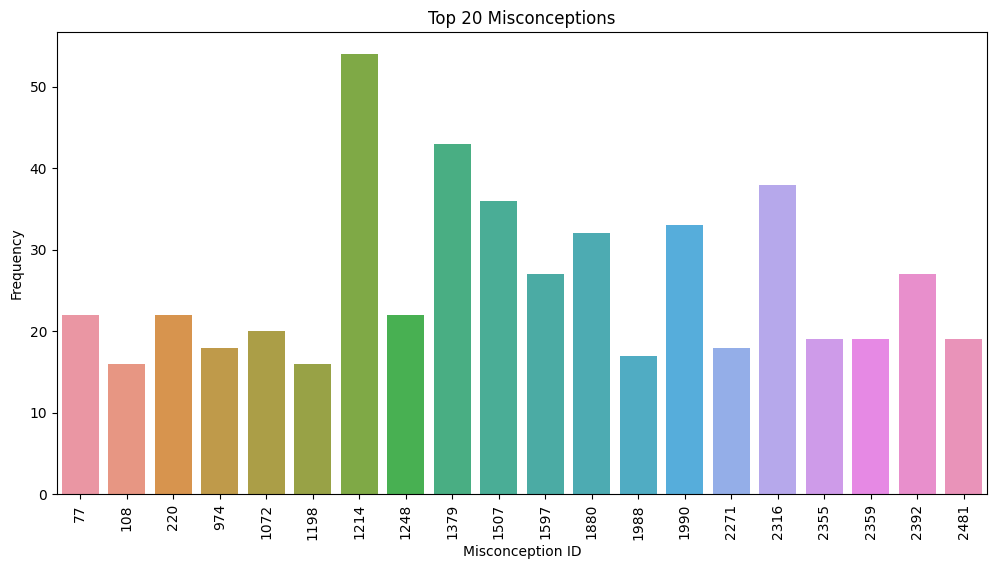

In [10]:
misconception_counts = misconceptions.value_counts()
top_20_misconceptions = misconception_counts.head(20).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_20_misconceptions.index.astype(int),
    y=top_20_misconceptions.values,
    order=top_20_misconceptions.index  
)
plt.title('Top 20 Misconceptions')
plt.xlabel('Misconception ID')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

Tên các hiểu nhầm phổ biến

In [11]:
misconception_counts_df = misconception_counts.reset_index()
misconception_counts_df.columns = ['MisconceptionId', 'Count']
misconception_counts_df = misconception_counts_df.merge(
    misconception_mapping, on='MisconceptionId', how='left'
)

print(misconception_counts_df.head(10))

   MisconceptionId  Count                                  MisconceptionName
0           1214.0     54  When solving an equation, uses the same operat...
1           1379.0     43                          Rounds down instead of up
2           2316.0     38  Mixes up squaring and multiplying by 2 or doub...
3           1507.0     36  Carries out operations from left to right rega...
4           1990.0     33                Fails to reflect across mirror line
5           1880.0     32        Mixes up greater than and less than symbols
6           1597.0     27  Believes multiplying two negatives gives a neg...
7           2392.0     27  Rounds to the wrong degree of accuracy (rounds...
8           1248.0     22  Rounds to the wrong degree of accuracy (rounds...
9             77.0     22  Does not follow the arrows through a function ...


Biểu đồ biểu diễn phân phối độ dài của câu hỏi

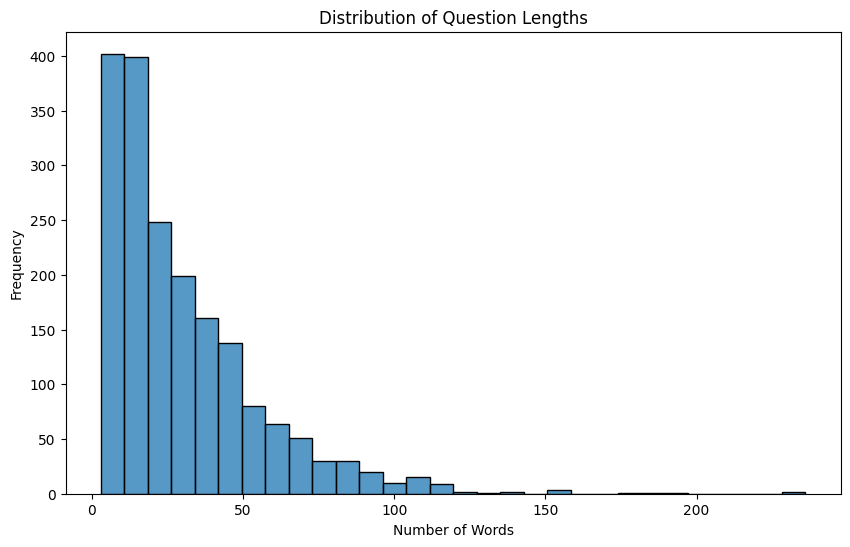

In [12]:
train['QuestionLength'] = train['QuestionText'].apply(lambda x: len(str(x).split()))
train['AnswerALength'] = train['AnswerAText'].apply(lambda x: len(str(x).split()))
train['AnswerBLength'] = train['AnswerBText'].apply(lambda x: len(str(x).split()))
train['AnswerCLength'] = train['AnswerCText'].apply(lambda x: len(str(x).split()))
train['AnswerDLength'] = train['AnswerDText'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,6))
sns.histplot(train['QuestionLength'], bins=30)
plt.title('Distribution of Question Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

Biểu đồ biểu diễn phân phối độ dài của các câu trả lời

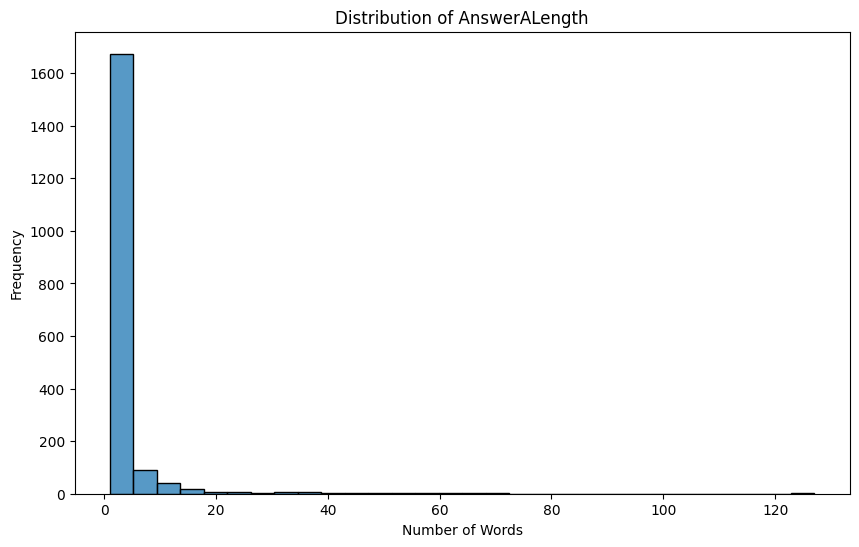

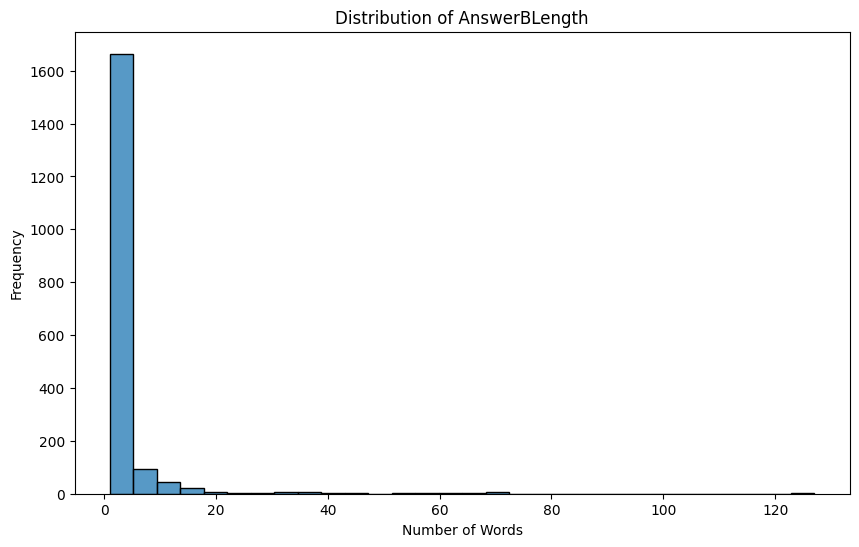

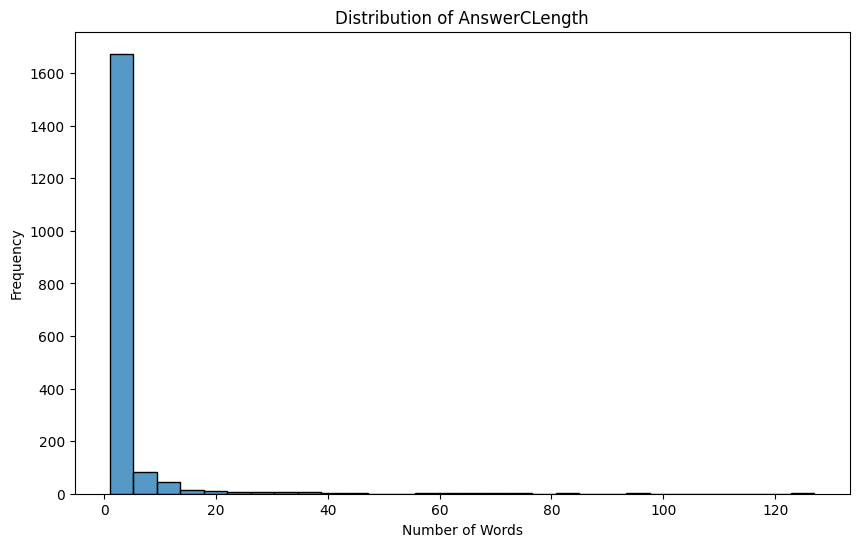

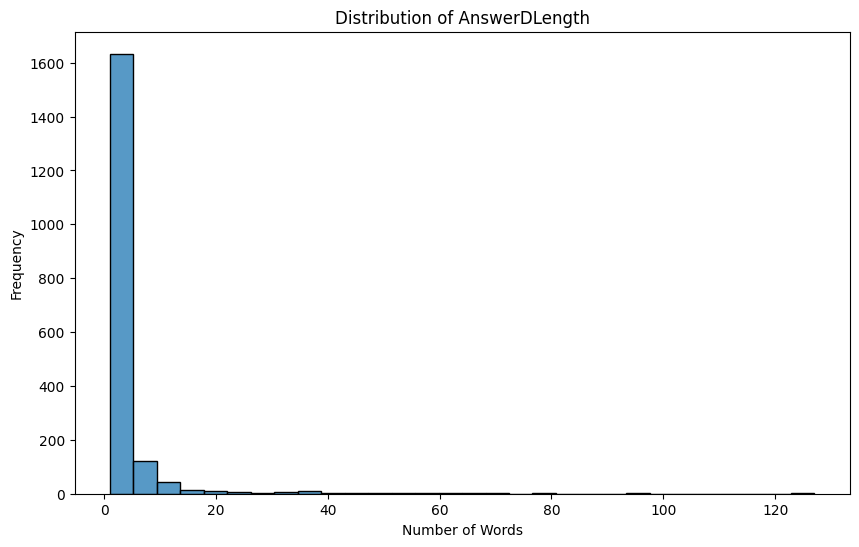

In [13]:
answer_lengths = ['AnswerALength', 'AnswerBLength', 'AnswerCLength', 'AnswerDLength']
for col in answer_lengths:
    plt.figure(figsize=(10,6))
    sns.histplot(data=train, x=col, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()

In [14]:
print("Missing values in 'QuestionText':", train['QuestionText'].isnull().sum())
print("Missing values in 'AnswerAText':", train['AnswerAText'].isnull().sum())
print("Missing values in 'AnswerBText':", train['AnswerBText'].isnull().sum())
print("Missing values in 'AnswerCText':", train['AnswerCText'].isnull().sum())
print("Missing values in 'AnswerDText':", train['AnswerDText'].isnull().sum())

Missing values in 'QuestionText': 0
Missing values in 'AnswerAText': 0
Missing values in 'AnswerBText': 0
Missing values in 'AnswerCText': 0
Missing values in 'AnswerDText': 0


<a id="3.1"></a>
<h2 style="font-family: Verdana; font-size: 25px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: #0A800B;"><b>Chuẩn bị dữ liệu </b></h2>

Load tệp trọng số (adapter.bin) của mô hình LoRA (Low-Rank Adaptation of Large Language Models) đã được huấn luyện và mô hình qwen2.5.

In [15]:
path_prefix = "/kaggle/input/eedi-mining-misconceptions-in-mathematics"
model_path = "/kaggle/input/qwen2.5-14/pytorch/default/1"
lora_path='/kaggle/input/qwen14b-it-lora/lora_weights/adapter.bin'
device='cuda:0'
VALID = False

Các hàm cần thiết cho mô hình

In [16]:
def apk(actual, predicted, k=25):
    """
    Tính Average Precision at K (AP@K) giữa hai danh sách:
        actual: Danh sách phần tử đúng (đáp án thực sự).
        predicted: Danh sách phần tử dự đoán.
    Tham số:
        actual: Danh sách chứa các phần tử đúng (không cần thứ tự).
        predicted: Danh sách phần tử được dự đoán (thứ tự quan trọng).
        k: Số lượng phần tử tối đa trong danh sách dự đoán cần xem xét.
    """
    
    if not actual:
        return 0.0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        # kiểm tra xem nó có phải là dự đoán hợp lệ
        # kiểm tra xem dự đoán có được lặp lại không
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def mapk(actual, predicted, k=25):
    """
    Tính Mean Average Precision at K (MAP@K) trên nhiều danh sách:
        actual: Danh sách các danh sách phần tử đúng.
        predicted: Danh sách các danh sách phần tử dự đoán.
    Tham số:
        actual: Danh sách các danh sách đáp án đúng.
        predicted: Danh sách các danh sách dự đoán.
        k: Số lượng phần tử tối đa cần xem xét.
    """
    # Tính trung bình của tất cả các giá trị AP@K để trả về
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def batch_to_device(batch, target_device):
    """
    Di chuyển một batch dữ liệu PyTorch tới thiết bị cụ thể (CPU/GPU).
    """
    for key in batch:
        if isinstance(batch[key], Tensor):
            batch[key] = batch[key].to(target_device)
    return batch

def last_token_pool(last_hidden_states: Tensor,
                    attention_mask: Tensor) -> Tensor:
    """
        Trích xuất vector biểu diễn cuối cùng từ trạng thái ẩn của mô hình Transformer.
        Trả về tensor biểu diễn vector của token cuối cùng.
    """
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]

def get_detailed_instruct(task_description: str, query: str) -> str:
    """
        Tạo chuỗi hướng dẫn chi tiết từ một nhiệm vụ và truy vấn.
    """
    return f'Instruct: {task_description}\nQuery: {query}'

def inference(df, model, tokenizer, device):
    """
        Thực hiện suy luận trên dữ liệu và trả về vector nhúng cho từng truy vấn.
        Trả về một dictionary với pids làm key và embedding làm giá trị.
    """
    batch_size = 16
    max_length = 512
    sentences = list(df['query_text'].values) # danh sách câu truy vấn 
    pids = list(df['order_index'].values)
    all_embeddings = []
    length_sorted_idx = np.argsort([-len(sen) for sen in sentences])
    sentences_sorted = [sentences[idx] for idx in length_sorted_idx]
    for start_index in trange(0, len(sentences), batch_size, desc="Batches", disable=False):
        sentences_batch = sentences_sorted[start_index: start_index + batch_size]
        features = tokenizer(sentences_batch, max_length=max_length, padding=True, truncation=True,
                             return_tensors="pt")
        features = batch_to_device(features, device)
        with torch.no_grad():
            outputs = model(**features)
            embeddings = last_token_pool(outputs.last_hidden_state, features['attention_mask'])
            embeddings = torch.nn.functional.normalize(embeddings, dim=-1)
            embeddings = embeddings.detach().cpu().numpy().tolist()
        all_embeddings.extend(embeddings)

    all_embeddings = [np.array(all_embeddings[idx]).reshape(1, -1) for idx in np.argsort(length_sorted_idx)]

    sentence_embeddings = np.concatenate(all_embeddings, axis=0)
    result = {pids[i]: em for i, em in enumerate(sentence_embeddings)}
    return result

Mô tả nhiệm vụ để sử dụng làm prompt cho các bước xử lý tiếp theo

In [17]:
task_description = 'Given a math question with correct answer and a misconcepted incorrect answer, retrieve the most accurate misconception for the incorrect answer.'

In [18]:
if VALID:
    tra = pd.read_parquet("/kaggle/input/val-parquet/v1_val.parquet")
    print(tra.shape)
else:
    tra = pd.read_csv(f"{path_prefix}/test.csv")
    print(tra.shape)
misconception_mapping = pd.read_csv(f"{path_prefix}/misconception_mapping.csv")
if tra.shape[0]<10:
    misconception_mapping = misconception_mapping.sample(n=5,random_state=2023)

(3, 11)


Tạo dữ liệu huấn luyện thông tin chi tiết (câu hỏi, đáp án đúng, đáp án sai, ánh xạ hiểu lầm)

In [19]:
if VALID:
    train_data = []
    for _,row in tra.iterrows():
        for c in ['A','B','C','D']:
            if str(row[f"Misconception{c}Id"])!="nan":
                real_answer_id = row['CorrectAnswer']
                real_text = row[f'Answer{real_answer_id}Text']
                query_text = f"### SubjectName: {row['SubjectName']}\n### ConstructName: {row['ConstructName']}\n### Question: {row['QuestionText']}\n### Correct Answer: {real_text}\n### Misconcepte Incorrect answer: {row[f'Answer{c}Text']}"
                row['query_text'] = get_detailed_instruct(task_description,query_text)
                row['answer_id'] = int(row[f"Misconception{c}Id"])
                train_data.append(copy.deepcopy(row))
    train_df = pd.DataFrame(train_data)
    train_df['order_index'] = list(range(len(train_df)))
else:
    train_data = []
    for _,row in tra.iterrows():
        for c in ['A','B','C','D']:
            if c == row['CorrectAnswer']:
                continue
            if f'Answer{c}Text' not in row:
                continue
            real_answer_id = row['CorrectAnswer']
            real_text = row[f'Answer{real_answer_id}Text']
            # Tạo câu truy vấn
            query_text = f"### SubjectName: {row['SubjectName']}\n### ConstructName: {row['ConstructName']}\n### Question: {row['QuestionText']}\n### Correct Answer: {real_text}\n### Misconcepte Incorrect answer: {row[f'Answer{c}Text']}"
            row['query_text'] = get_detailed_instruct(task_description,query_text)
            row['answer_name'] = c

            # misconception_id = misconception_mapping[misconception_mapping['MisconceptionName'] == row[f'Answer{c}Text']]['MisconceptionId'].values
            # if len(misconception_id) > 0:
            #     row['CorrectMisconceptionIds'] = misconception_id[0]  
            # else:
            #     row['CorrectMisconceptionIds'] = None  

            train_data.append(copy.deepcopy(row))
    train_df = pd.DataFrame(train_data)
    train_df['order_index'] = list(range(len(train_df)))
train_df.shape

(9, 14)

<a id="3.1"></a>
<h2 style="font-family: Verdana; font-size: 25px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: #0A800B;"><b>Mô hình </b></h2>

Link model: https://www.kaggle.com/models/trainld/qwen2.5-14/PyTorch/default  
Tài liệu trên giới thiệu về Qwen2.5-14B-Instruct, một mô hình ngôn ngữ lớn (LLM) được phát triển bởi Alibaba Cloud, với các đặc điểm nổi bật và hướng dẫn triển khai cơ bản. Dưới đây là phần giải thích chi tiết:

Qwen2.5 là phiên bản nâng cấp của dòng mô hình Qwen, với các cải tiến vượt trội so với Qwen2:
-   Tăng cường kiến thức và khả năng: Đặc biệt mạnh về lập trình, toán học, và dữ liệu có cấu trúc (như bảng, JSON).
-   Hỗ trợ ngữ cảnh dài: Lên đến 131.072 tokens, với khả năng sinh văn bản mới tối đa 8.192 tokens.
-   Đa ngôn ngữ: Hỗ trợ hơn 29 ngôn ngữ như tiếng Trung, Anh, Pháp, Đức, Nhật, Việt, Thái, Ả Rập, v.v.
-   Cải thiện khả năng thực hiện theo hướng dẫn: Sinh các văn bản dài, bền bỉ hơn với nhiều loại prompt khác nhau, đặc biệt hiệu quả trong thiết lập chatbot.

Thông tin kỹ thuật
-   Loại: Mô hình ngôn ngữ nhân quả (Causal Language Model).
-   Số lượng tham số: Tổng 14.7 tỷ (13.1 tỷ tham số không liên quan đến nhúng).
-   Kiến trúc: Sử dụng RoPE, SwiGLU, RMSNorm, và Attention QKV bias.
-   Ngữ cảnh tối đa: 131.072 tokens.
-   Hỗ trợ xử lý văn bản dài: Có thể mở rộng ngữ cảnh lên đến 32.768 tokens bằng kỹ thuật YaRN (Y-Axis Rope Scaling).


#### Fine-tuning với LoRA (Low-Rank Adaptation of Large Language Models)
LoRA là một kỹ thuật fine-tuning hiệu quả, được thiết kế để tối ưu hóa các mô hình ngôn ngữ lớn (LLMs) bằng cách thêm các trọng số hạng thấp vào kiến trúc hiện có, thay vì cập nhật toàn bộ trọng số của mô hình.

Nguyên lý hoạt động của LoRA:
-   Freeze model weights: Trọng số của mô hình gốc không bị cập nhật, giúp giảm chi phí tính toán và bộ nhớ.
-   Low-rank matrices: Thêm các ma trận hạng thấp vào các thành phần quan trọng như  `q_proj`, `k_proj`, `v_proj`, `o_proj`.
-   Công thức: $ W_{\text{new}} = W + \Delta W ,\quad \text{với} \quad \Delta W = A \cdot B $

-   Fast adaptation: LoRA chỉ huấn luyện các trọng số thêm này, cho phép mô hình thích nghi với nhiệm vụ mới mà không cần thay đổi toàn bộ trọng số ban đầu.

In [20]:
# Khởi tạo AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(lora_path.replace("/adapter.bin",""))

bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16
        )
# Tải mô hình 
model = AutoModel.from_pretrained(model_path, 
                                  quantization_config=bnb_config, 
                                  device_map=device,
                                  trust_remote_code=True)

# Tạo cấu hình LoRA
if lora_path:
    print("loading lora")
    config = LoraConfig(
        r=64,
        lora_alpha=128,
        target_modules=[
            "q_proj",
            "k_proj",
            "v_proj",
            "o_proj",
            "gate_proj",
            "up_proj",
            "down_proj",
        ],
        bias="none",
        lora_dropout=0.05,  # Conventional
        task_type="FEATURE_EXTRACTION",
    )
    model = get_peft_model(model, config) 
    d = torch.load(lora_path, map_location=model.device) # Tải trọng số LoRA
    model.load_state_dict(d, strict=False)
    model = model.merge_and_unload()
    
# Chuyển mô hình về chế độ suy luận
model = model.eval()


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

loading lora


Tạo embeddings cho tập train

In [21]:
train_embeddings = inference(train_df, model, tokenizer, device)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Tạo embeddings cho các hiểu nhầm

In [22]:
misconception_mapping['query_text'] = misconception_mapping['MisconceptionName']
misconception_mapping['order_index'] = misconception_mapping['MisconceptionId']
doc_embeddings = inference(misconception_mapping, model, tokenizer, device)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
sentence_embeddings = np.concatenate([e.reshape(1, -1) for e in list(doc_embeddings.values())])
index_text_embeddings_index = {index: paper_id for index, paper_id in
                                         enumerate(list(doc_embeddings.keys()))}

Tính toán độ tương đồng cosine giữa câu hỏi và các hiểu nhầm

In [24]:
predicts_test = []
for _, row in tqdm(train_df.iterrows()):
    query_id = row['order_index']
    query_em = train_embeddings[query_id].reshape(1, -1)
    # Tính toán cosine similarity giữa query và các câu trả lời trong phần Misconception
    cosine_similarity = np.dot(query_em, sentence_embeddings.T).flatten()
    # Sắp xếp các giá trị cosine similarity để chọn ra các dự đoán top-k
    sort_index = np.argsort(-cosine_similarity)[:25]
    pids = [index_text_embeddings_index[index] for index in sort_index]
    predicts_test.append(pids)

0it [00:00, ?it/s]

In [ ]:
# actual = [row['CorrectMisconceptionIds'] for _, row in train_df.iterrows()]
# map_score = mapk(actual, predicts_test, k=25)
# print(f"MAP@25 Score: {map_score}")

Tạo tệp kết quả

In [25]:
if VALID:
    train_df['recall_ids'] = predicts_test
    print(mapk([[data] for data in train_df['answer_id'].values],train_df['recall_ids'].values))
else:
    train_df['MisconceptionId'] = [' '.join(map(str,c)) for c in predicts_test]
    sub = []
    for _,row in train_df.iterrows():
        sub.append(
            {
                "QuestionId_Answer":f"{row['QuestionId']}_{row['answer_name']}",
                "MisconceptionId":row['MisconceptionId']
            }
        )
    submission_df = pd.DataFrame(sub)
    submission_df.to_csv("submission.csv", index=False)
    print("Submission file created successfully!")

Submission file created successfully!
